In [1]:
#https://github.com/sneha3799/CycleGAN-Monet2photo/blob/master/cyclegan.py

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (Activation, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

%matplotlib inline

/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# Load dataset
data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

train_x, train_y, test_x, test_y = data['trainA'], data['trainB'], data['testA'], data['testB']

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-12-04 20:47:40.440261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 20:47:40.440384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Settings
epochs = 50

LAMBDA = 10

img_rows, img_cols, channels = 256, 256, 3
weight_initializer = RandomNormal(stddev=0.02)

gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# Normalize images to [-1, 1] and reshape
def preprocess_image(image, _):
    return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))

In [6]:
# Map the normalization onto the dataset
train_x = train_x.map(preprocess_image)
train_y = train_y.map(preprocess_image)
test_x = test_x.map(preprocess_image)
test_y = test_y.map(preprocess_image)

In [7]:
# "Ck denotes a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2
def Ck(input, k, use_instancenorm=True):
    block = Conv2D(k, (4, 4), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    if use_instancenorm:
        block = InstanceNormalization(axis=-1)(block)
    block = LeakyReLU(0.2)(block)

    return block

# C64, C128, C256, C512
def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))

    d = Ck(dis_input, 64, False)
    d = Ck(d, 128)
    d = Ck(d, 256)
    d = Ck(d, 512)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)

    return Model(dis_input, d)

In [8]:
# "dk denotes a 3×3 Convolution-InstanceNorm-ReLU with k filters and stride 2"
def dk(k, use_instancenorm=True):
    block = Sequential()
    block.add(Conv2D(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    if use_instancenorm:
        block.add(InstanceNormalization(axis=-1))
    block.add(Activation('relu'))

    return block

# "uk denotes a 3×3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride ½"
def uk(k):
    block = Sequential()
    block.add(Conv2DTranspose(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    block.add(InstanceNormalization(axis=-1))
    block.add(Activation('relu'))

    return block

def generator():
    gen_input = Input(shape=(img_rows, img_cols, channels))
    
    # Layers for the encoder part of the model
    encoder_layers = [
        dk(64, False),
        dk(128),
        dk(256),
        dk(512),
        dk(512),
        dk(512),
        dk(512),
        dk(512)
    ]

    # Layers for the decoder part of the model
    decoder_layers = [
        uk(512),
        uk(512),
        uk(512),
        uk(512),
        uk(256),
        uk(128),
        uk(64)
    ]

    gen = gen_input

    # Add all the encoder layers, and keep track of them for skip connections
    skips = []
    for layer in encoder_layers:
        gen = layer(gen)
        skips.append(gen)
    
    skips = skips[::-1][1:] # Reverse for looping and get rid of the layer that directly connects to decoder

    # Add all the decoder layers and skip connections
    for skip_layer, layer in zip(skips, decoder_layers):
        gen = layer(gen)
        gen = Concatenate()([gen, skip_layer])

    
    # Final layer
    gen = Conv2DTranspose(channels, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer, activation='tanh')(gen)
    
    # Compose model
    return Model(gen_input, gen)

In [9]:
# Define the models
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

In [10]:
 # Losses
loss = BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def call(self, inputs):
        return (
            self.m_disc(inputs),
            self.p_disc(inputs),
            self.m_gen(inputs),
            self.p_gen(inputs),
        )

        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [12]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):

            # Sample images
        x = next(iter(test_x.shuffle(1000))).numpy()
        y = next(iter(test_y.shuffle(1000))).numpy()
        
        # Get predictions for those images
        y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
        x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
        plt.figure(figsize=(12, 12))

        images = [x[0], y_hat[0], y[0], x_hat[0]]

        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.imshow(images[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.tight_layout()
        plt.show()



2022-12-04 20:47:54.282055: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 20:48:03.865388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1072/1072 [==============================] - ETA: 0s - monet_gen_loss: 4.2722 - photo_gen_loss: 4.3118 - monet_disc_loss: 0.6687 - photo_disc_loss: 0.6616

2022-12-04 20:52:51.819962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-04 20:52:53.232366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


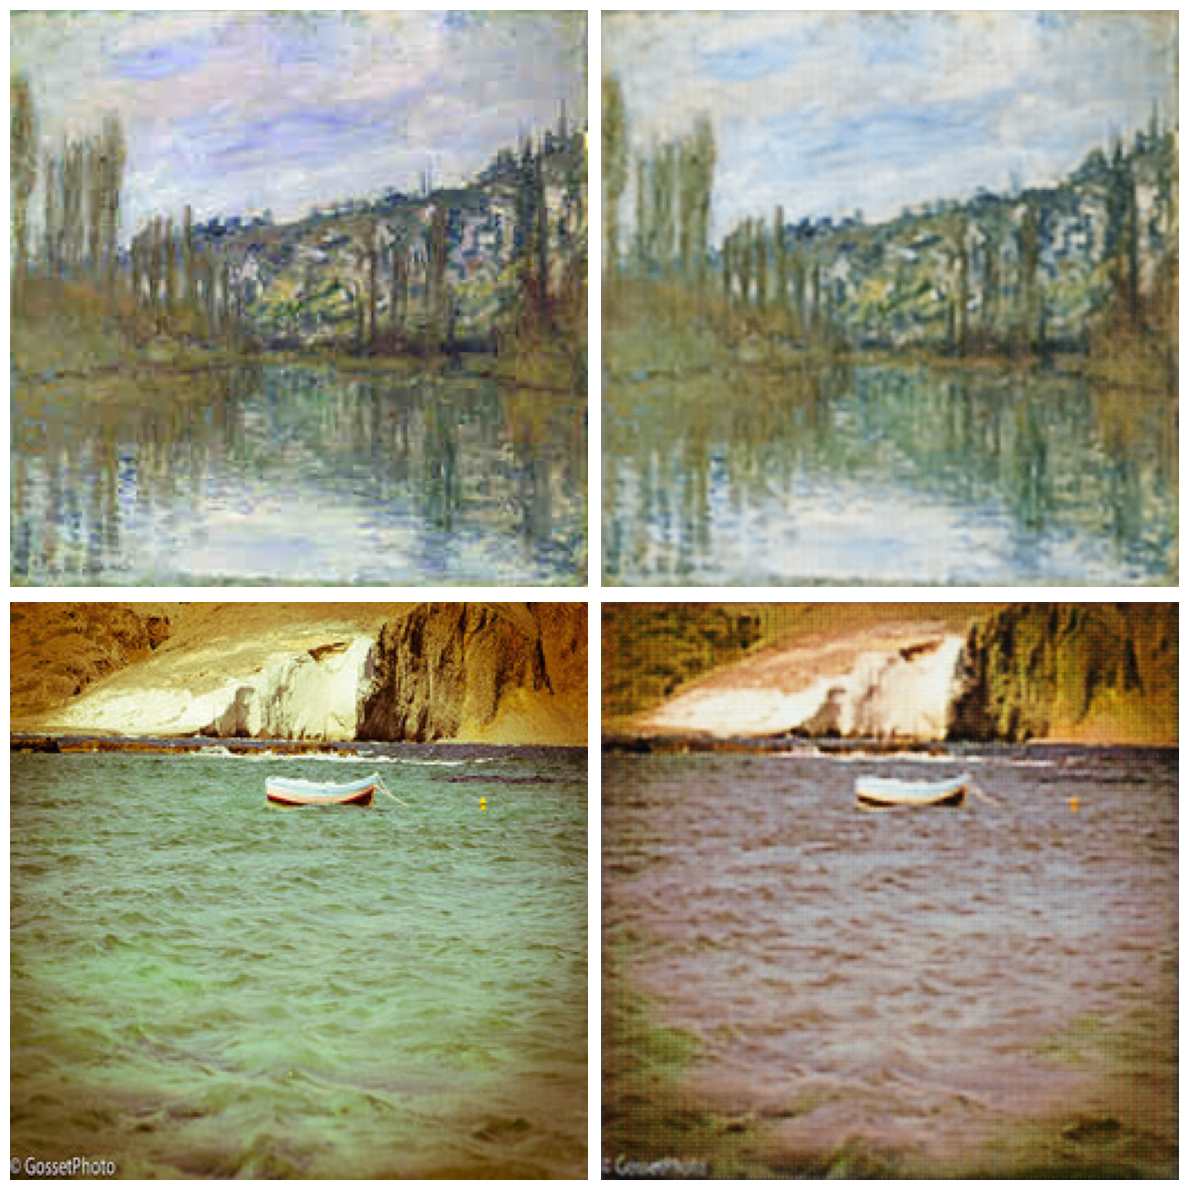

ValueError: Model <__main__.CycleGan object at 0x2c4f04d00> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined when calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)

In [13]:

# Create cycle gan model
cycle_gan_model = CycleGan(
    monet_generator=generator_g, photo_generator=generator_f, monet_discriminator=discriminator_x, photo_discriminator=discriminator_y
)

# Compile the model
cycle_gan_model.compile(
    m_gen_optimizer = gen_g_optimizer,
    p_gen_optimizer = gen_f_optimizer,
    m_disc_optimizer = dis_x_optimizer,
    p_disc_optimizer = dis_y_optimizer,
    gen_loss_fn = gen_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_log.csv", append=True)


# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_x, train_y)),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback, csv_logger],
)

In [ ]:
train_x

In [ ]:
train_y

In [ ]:
generator_g.save('generator_g.h5')
generator_f.save('generator_f.h5')
discriminator_x.save('discriminator_x.h5')
discriminator_y.save('discriminator_y.h5')

In [32]:
cycle_gan_model.save("checkpoints/test_model")


ValueError: Model <__main__.CycleGan object at 0x3b5b56e20> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined when calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)

In [31]:
cycle_gan_model.build((1, 256, 256, 3))

In [33]:
cycle_gan_model.save_weights("checkpoints/test_model")


In [34]:
cycle_gan_model = CycleGan(
    monet_generator=generator_g, photo_generator=generator_f, monet_discriminator=discriminator_x, photo_discriminator=discriminator_y
)

In [35]:
# Compile the model
cycle_gan_model.compile(
    m_gen_optimizer = gen_g_optimizer,
    p_gen_optimizer = gen_f_optimizer,
    m_disc_optimizer = dis_x_optimizer,
    p_disc_optimizer = dis_y_optimizer,
    gen_loss_fn = gen_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [36]:
cycle_gan_model.load_weights("checkpoints/test_model")

2022-12-04 21:56:14.827493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1072/1072 [==============================] - ETA: 0s - monet_gen_loss: 2.9606 - photo_gen_loss: 3.0386 - monet_disc_loss: 0.6373 - photo_disc_loss: 0.6284

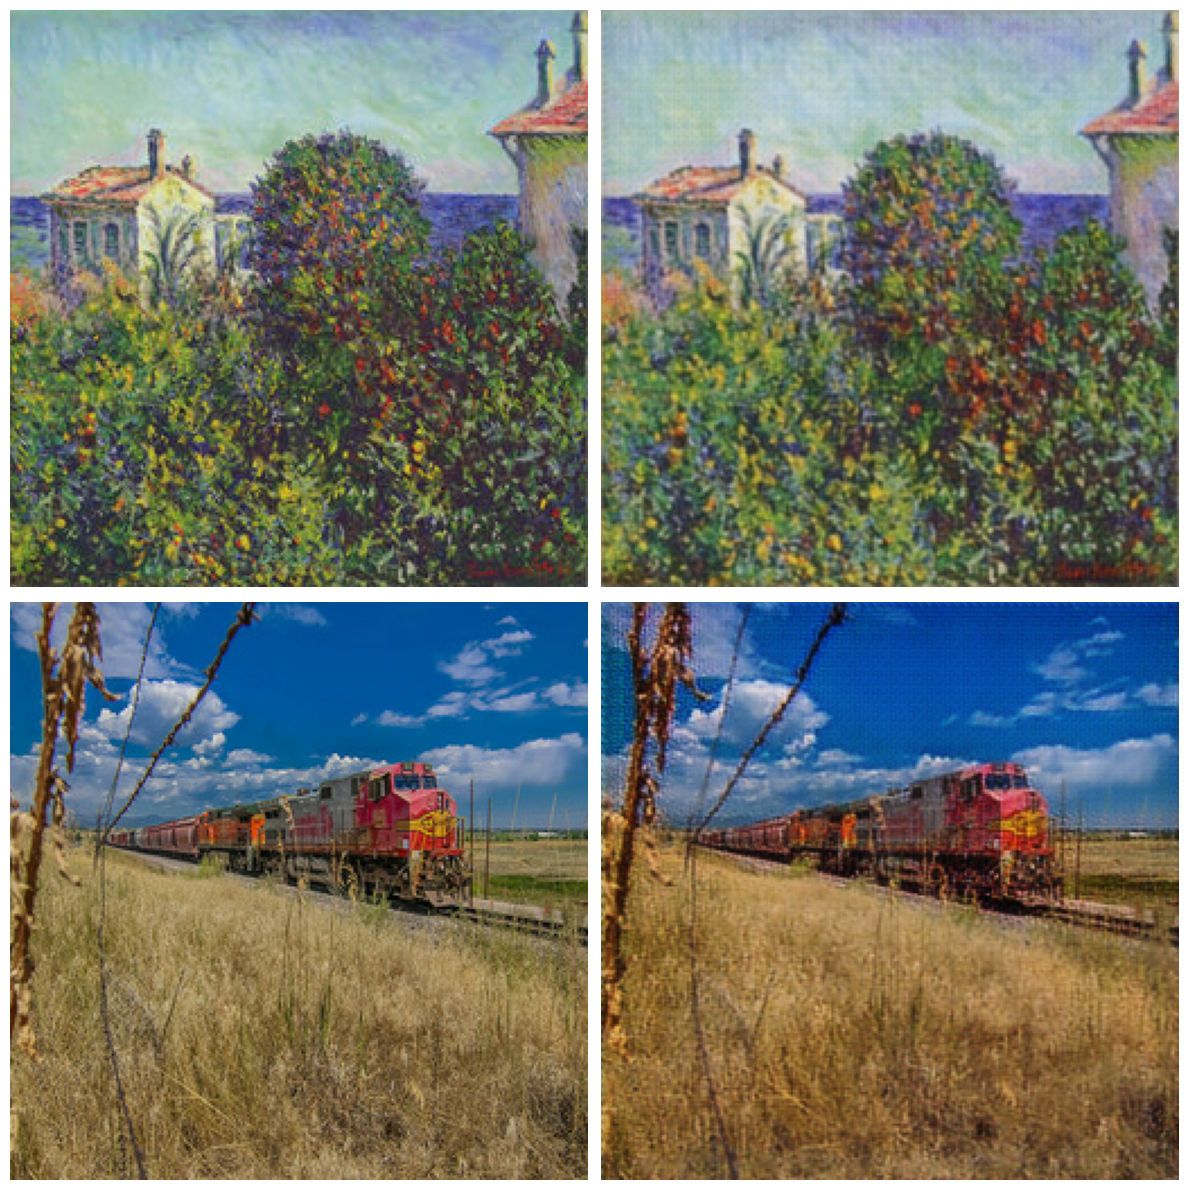

1072/1072 [==============================] - 377s 302ms/step - monet_gen_loss: 2.9608 - photo_gen_loss: 3.0396 - monet_disc_loss: 0.6371 - photo_disc_loss: 0.6283


In [37]:

# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_log.csv", append=True)


# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_x, train_y)),
    epochs=2,
    callbacks=[plotter, model_checkpoint_callback, csv_logger],
)